In [1]:
### Brian Tao: X-Ray Bone Fracture Classifier

### All code is run on Google Collab's Cloud Services
### Python 3 Google Compute Engine backend (GPU)

### Dataset obtained from VUPPALA ADITHYA SAIRAM on Kaggle

### Initial Dataset processing follows Author's baseline code

from google.colab import drive
drive.mount('/content/gdrive')
!unzip -qq /content/gdrive/MyDrive/datasets/bone_xray_files.zip -d /content

Mounted at /content/gdrive


In [2]:
### Importing all the relevant libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt

!pip install -q visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 7.5 MB/s eta 0:00:00


In [3]:
train_path = '/content/archive (6)/train'
val_path = '/content/archive (6)/val'


iamge_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
)

batch_size_val = 64

train_ds = iamge_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary', 
    color_mode = 'grayscale',
    subset='training',
    shuffle=True)

val_ds = iamge_datagen.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = batch_size_val,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle=True)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


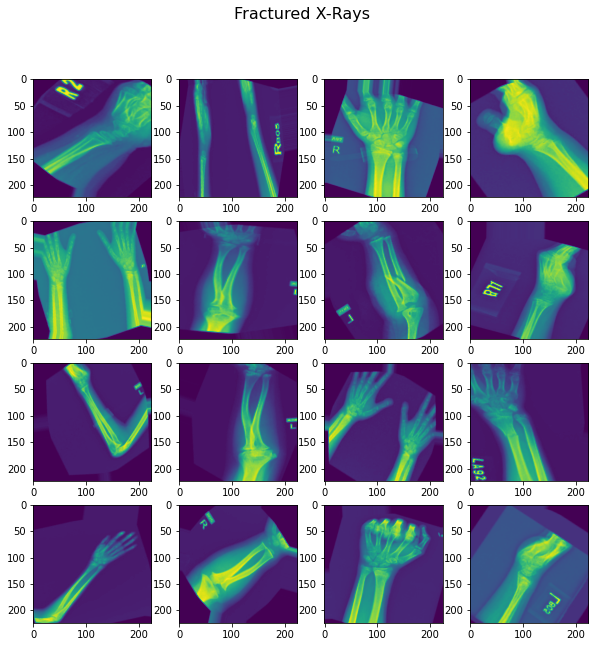

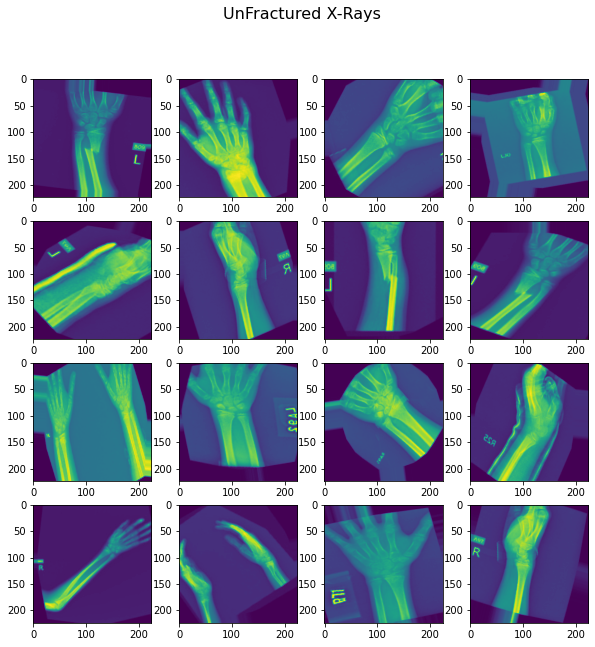

In [4]:
### Display of 16 images for both the Fractured and UnFractured X-Rays in the Training Dataset

frac_imgs = []
unfrac_imgs = []
for i in range(16):
  frac_imgs.append(train_ds[0][0][i])
  unfrac_imgs.append(train_ds[1][0][i])

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(frac_imgs, axs):
    ax.imshow(img)
fig.suptitle("Fractured X-Rays", fontsize=16)
plt.show()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(unfrac_imgs, axs):
    ax.imshow(img)
fig.suptitle("UnFractured X-Rays", fontsize=16)
plt.show()



In [8]:

### Convolutional Neural Network model for Binary Classification 

### 2 possible Predictions (Fracture or No Fracture)

num_classes = 1

model = keras.Sequential(
    [
        ### Input layer and Preprocessing
     
        keras.Input(shape=((224, 224, 1))),
        tf.keras.layers.Rescaling(scale=1/.255, offset=0.0),
     
        ### Convolution & Pooling layers

        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),        
     
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),        
     
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),        
     
        # layers.Conv2D(1024, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     
        ### Fully Connected Layers

        layers.Flatten(),     
        # layers.Dense(1024, activation='relu'),
        # layers.BatchNormalization(),
     
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
     
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"), 
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 1)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 109, 109, 64)    

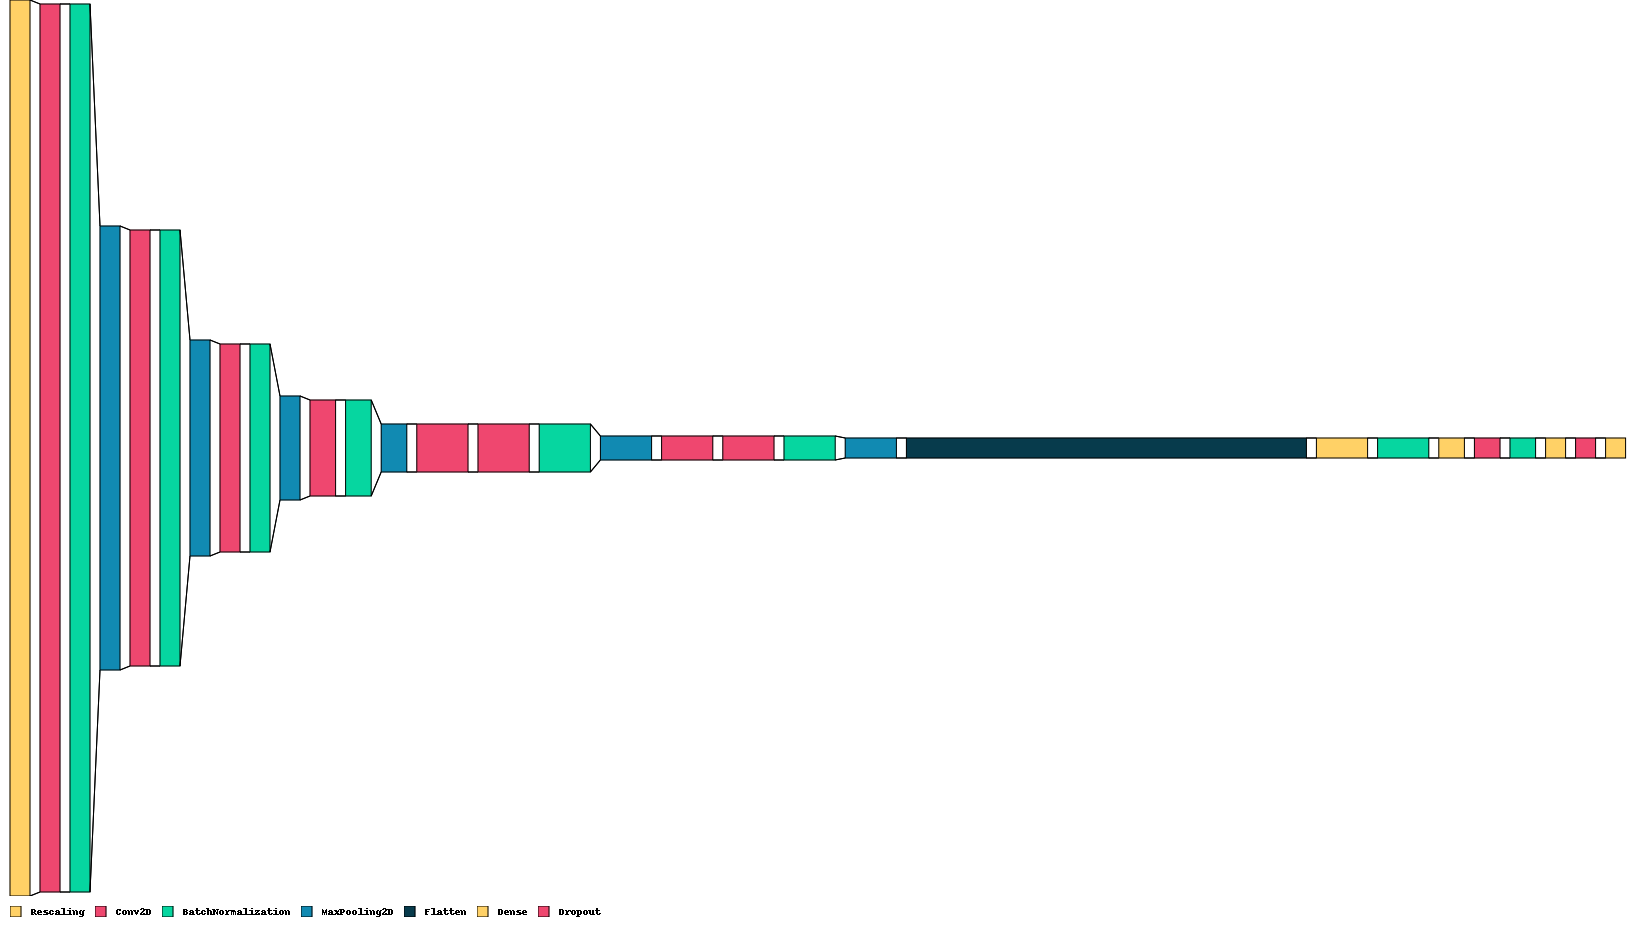

In [9]:
### Visualization of the Generated Model via VisualKeras Library

visualkeras.layered_view(model, legend=True, draw_volume=False)

In [10]:
### HyperParameters. Early Stop implemented via callback

epochs = 20
checkpoint_filepath = '/content/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, 
    verbose=1)
lrp=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=round(epochs/5))

### Training the Model with the HyperParameters set above

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback, lrp]) # Validation data instead of fraction

Epoch 1/20
139/139 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.5679
Epoch 1: val_accuracy improved from -inf to 0.57167, saving model to /content/tmp/checkpoint
139/139 [==============================] - 67s 429ms/step - loss: 0.7444 - accuracy: 0.5679 - val_loss: 0.7979 - val_accuracy: 0.5717 - lr: 0.0010
Epoch 2/20
139/139 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6246
Epoch 2: val_accuracy did not improve from 0.57167
139/139 [==============================] - 59s 420ms/step - loss: 0.6473 - accuracy: 0.6246 - val_loss: 0.7342 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 3/20
139/139 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.6786
Epoch 3: val_accuracy did not improve from 0.57167
139/139 [==============================] - 61s 435ms/step - loss: 0.5692 - accuracy: 0.6786 - val_loss: 1.4956 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 4/20
139/139 [==============================] - ETA: 0s - loss: 0.5005

In [14]:
### Testing most-trained model based on accuracy of training set and validation set

model.evaluate(train_ds)
model.evaluate(val_ds)

10/10 [==============================] - 3s 308ms/step - loss: 0.9654 - accuracy: 0.7417


[0.9654461741447449, 0.7416666746139526]

In [16]:
### Testing 'best' model determined by callback hyperparameters based on accuracy of training set and validation set

model1= keras.models.clone_model(model)
model1.load_weights(checkpoint_filepath)
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.evaluate(train_ds)
model1.evaluate(val_ds)

10/10 [==============================] - 5s 481ms/step - loss: 0.6979 - accuracy: 0.7783


[0.6979240775108337, 0.778333306312561]

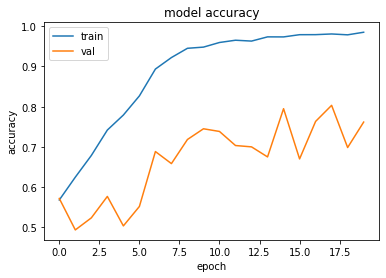

In [17]:
### Plotting the Training Accuracy and Validation Accuracy throughout Epochs

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

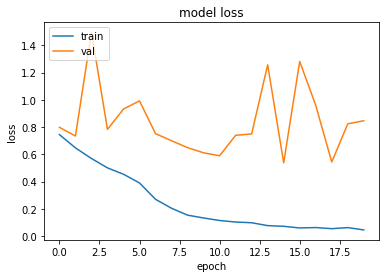

In [18]:
### Plotting the Training Loss and Validation Loss throughout Epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
### Saving models from environment

model.save('/content/gdrive/MyDrive/models/complete_model')
model1.save('/content/gdrive/MyDrive/models/best_model')